# Shinkansen Bullet Train — Passenger Satisfaction Prediction (V5)

## Mission Statement

Predict whether a Shinkansen (bullet train) passenger was **satisfied** (1) or **not satisfied** (0) with their overall travel experience, based on travel attributes and post-service survey responses.

## Dataset

Two source datasets per split (train/test):
- **Travel Data** — passenger demographics and trip logistics: Gender, Customer Type, Age, Travel Purpose, Travel Class, Distance, Delays
- **Survey Data** — 14 post-service satisfaction ratings (ordinal, from "Extremely Poor" to "Excellent") plus Seat Class

Training set: **94,379** passengers. Test set: **35,602** passengers.  
Evaluation metric: **Accuracy**.

## Methodology

1. **Data exploration** — understand distributions, missing patterns, feature correlations
2. **Feature engineering** — aggregate survey statistics, delay ratios, missing value indicators, interaction features
3. **4-model stacking ensemble** — Optuna-tuned LightGBM + XGBoost + CatBoost + ExtraTrees with optimized weighted blending
4. **7-fold cross-validation** — more training data per fold (85.7% vs 80%), smoother OOF probabilities
5. **Seed averaging** — train with multiple random seeds, average predictions for stability

## Previous Results

| Version | Approach | Test Accuracy | Rank |
|---------|----------|---------------|------|
| V1 | Single LightGBM, manual params | 0.9555643 | 3rd |
| V2 | Optuna-tuned 3-model stacking (5-fold) | 0.9574743 | 2nd |
| V4 | + Pseudo-labeling (discarded — hurt accuracy) | 0.9569968 | — |
| **V5** | **+ ExtraTrees diversity, 7-fold CV** | **TBD** | **TBD** |

## V5 Key Changes

- **ExtraTrees** added as 4th base model — builds trees independently (bagging) with random split points, producing predictions that are genuinely uncorrelated with the GBDT trio
- **7-fold CV** replaces 5-fold — each model sees 85.7% of data per fold instead of 80%, producing smoother OOF probabilities
- **4-model weight optimization** — re-search optimal blending weights across all four models
- **Pseudo-labeling removed** — V4 showed it amplified errors rather than helping

In [1]:
# --- Imports & Configuration ---

import warnings
warnings.filterwarnings('ignore')

import glob
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# --- Reproducibility ---
SEED = 42
N_FOLDS = 7  # V5: upgraded from 5-fold to 7-fold
np.random.seed(SEED)

DATA_DIR = '.'

# --- GPU Configuration ---
# Set USE_GPU = False if running on a machine without a CUDA-capable GPU.
# LightGBM stays on CPU (pip build lacks CUDA). XGBoost and CatBoost use GPU.
USE_GPU = True

XGB_DEVICE = {'device': 'cuda'} if USE_GPU else {}
CB_DEVICE = {'task_type': 'GPU'} if USE_GPU else {}

# --- Optimized hyperparameters (from Optuna tuning in V2, 100 trials each) ---
BEST_LGB_PARAMS = {
    'n_estimators': 5000,
    'learning_rate': 0.02006130404098335,
    'max_depth': 10,
    'num_leaves': 82,
    'subsample': 0.6363020221407356,
    'colsample_bytree': 0.6163799680541543,
    'min_child_samples': 14,
    'reg_alpha': 0.4959859942324878,
    'reg_lambda': 0.028694549312225034,
    'random_state': SEED,
    'verbose': -1,
    'n_jobs': -1
}

BEST_XGB_PARAMS = {
    'n_estimators': 5000,
    'learning_rate': 0.02629765461385586,
    'max_depth': 10,
    'subsample': 0.933787944562583,
    'colsample_bytree': 0.8418629840543196,
    'min_child_weight': 2,
    'reg_alpha': 0.015500510498064968,
    'reg_lambda': 0.0024044203758951436,
    'gamma': 0.38915388203943474,
    'random_state': SEED,
    'eval_metric': 'error',
    'verbosity': 0,
    'n_jobs': -1,
    'tree_method': 'hist',
    **XGB_DEVICE
}

BEST_CB_PARAMS = {
    'iterations': 5000,
    'learning_rate': 0.06037233501239291,
    'depth': 8,
    'l2_leaf_reg': 0.24566928171583854,
    'border_count': 68,
    'bagging_temperature': 0.3576537029657124,
    'random_strength': 0.14575253908437555,
    'random_seed': SEED,
    'verbose': 0,
    'allow_writing_files': False,
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 100,
    **CB_DEVICE
}

# ExtraTrees params will be tuned by Optuna below

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('muted')

print(f'GPU enabled: {USE_GPU}')
print(f'CV folds: {N_FOLDS}')
print('Setup complete')

GPU enabled: True
CV folds: 7
Setup complete


In [2]:
# --- Data Loading & Merging ---

travel_train = pd.read_csv(f'{DATA_DIR}/Traveldata_train_(1).csv')
survey_train = pd.read_csv(f'{DATA_DIR}/Surveydata_train_(1).csv')
travel_test = pd.read_csv(f'{DATA_DIR}/Traveldata_test_(1).csv')
survey_test = pd.read_csv(f'{DATA_DIR}/Surveydata_test_(1).csv')

train = travel_train.merge(survey_train, on='ID', how='inner')
test = travel_test.merge(survey_test, on='ID', how='inner')

target_col = 'Overall_Experience'
y_train = train[target_col].values
test_ids = test['ID'].values

print(f'Training set: {train.shape[0]:,} passengers, {train.shape[1]} columns')
print(f'Test set:     {test.shape[0]:,} passengers, {test.shape[1]} columns')
print(f'\nTarget variable: {target_col}')
print(f'  Satisfied (1):     {(y_train == 1).sum():,} ({(y_train == 1).mean():.1%})')
print(f'  Not satisfied (0): {(y_train == 0).sum():,} ({(y_train == 0).mean():.1%})')

Training set: 94,379 passengers, 25 columns
Test set:     35,602 passengers, 24 columns

Target variable: Overall_Experience
  Satisfied (1):     51,593 (54.7%)
  Not satisfied (0): 42,786 (45.3%)


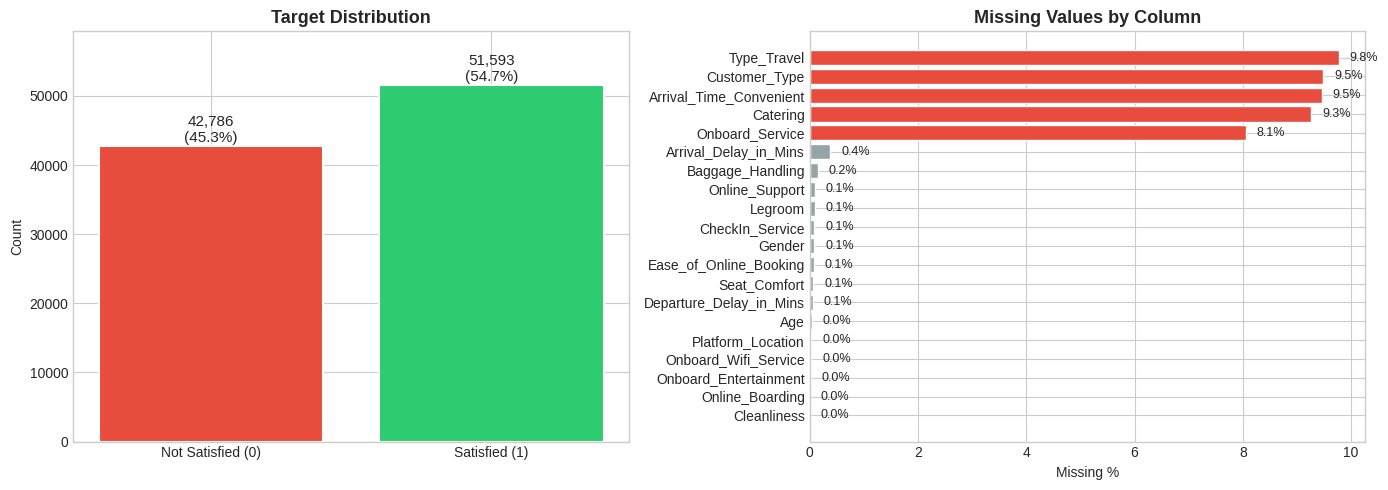

In [3]:
# --- EDA: Target Distribution & Missing Values ---

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Target distribution
ax = axes[0]
counts = pd.Series(y_train).value_counts().sort_index()
bars = ax.bar(['Not Satisfied (0)', 'Satisfied (1)'], counts.values,
              color=['#e74c3c', '#2ecc71'], edgecolor='white', linewidth=1.5)
for bar, count in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
            f'{count:,}\n({count/len(y_train):.1%})', ha='center', fontsize=11)
ax.set_title('Target Distribution', fontsize=13, fontweight='bold')
ax.set_ylabel('Count')
ax.set_ylim(0, max(counts.values) * 1.15)

# Missing values
ax = axes[1]
missing_pct = (train.isnull().sum() / len(train) * 100).sort_values(ascending=True)
missing_pct = missing_pct[missing_pct > 0]
colors = ['#e74c3c' if v > 5 else '#f39c12' if v > 1 else '#95a5a6' for v in missing_pct.values]
ax.barh(missing_pct.index, missing_pct.values, color=colors, edgecolor='white')
ax.set_xlabel('Missing %')
ax.set_title('Missing Values by Column', fontsize=13, fontweight='bold')
for i, (col, pct) in enumerate(missing_pct.items()):
    ax.text(pct + 0.2, i, f'{pct:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

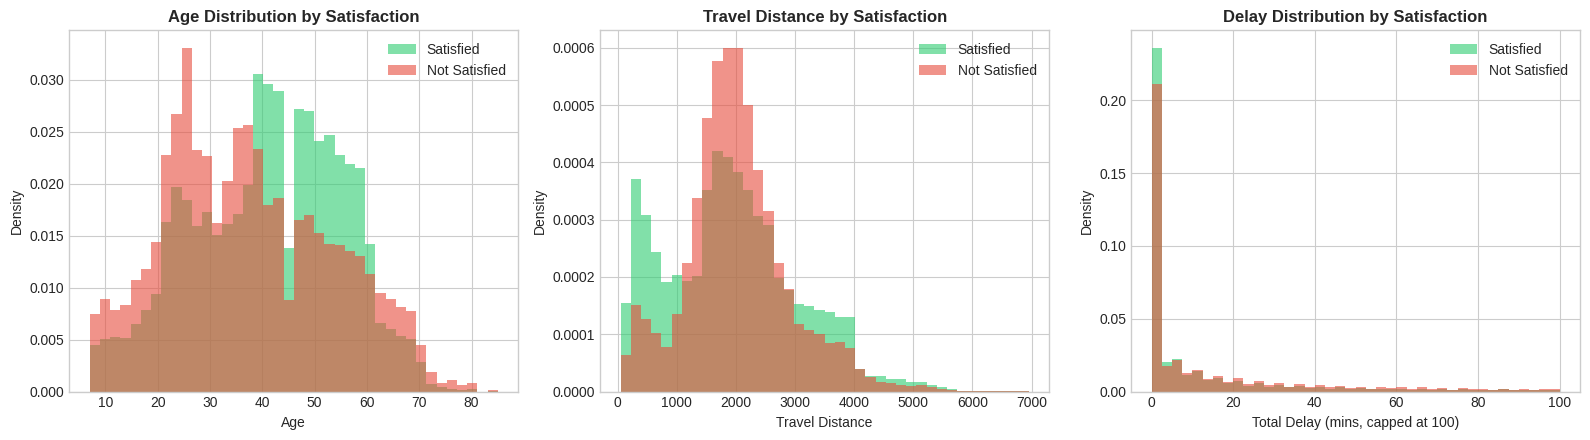

In [4]:
# --- EDA: Feature Distributions ---

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

for ax, col_name, title in zip(axes,
    ['Age', 'Travel_Distance', None],
    ['Age Distribution by Satisfaction', 'Travel Distance by Satisfaction', 'Delay Distribution by Satisfaction']):
    
    for label, color, name in [(1, '#2ecc71', 'Satisfied'), (0, '#e74c3c', 'Not Satisfied')]:
        if col_name:
            data = train.loc[train[target_col] == label, col_name].dropna()
        else:
            total_delay = train['Departure_Delay_in_Mins'].fillna(0) + train['Arrival_Delay_in_Mins'].fillna(0)
            data = total_delay[train[target_col] == label]
            data = data[data <= 100]
        ax.hist(data, bins=40, alpha=0.6, color=color, label=name, density=True)
    ax.set_ylabel('Density')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend()

axes[0].set_xlabel('Age')
axes[1].set_xlabel('Travel Distance')
axes[2].set_xlabel('Total Delay (mins, capped at 100)')

plt.tight_layout()
plt.show()

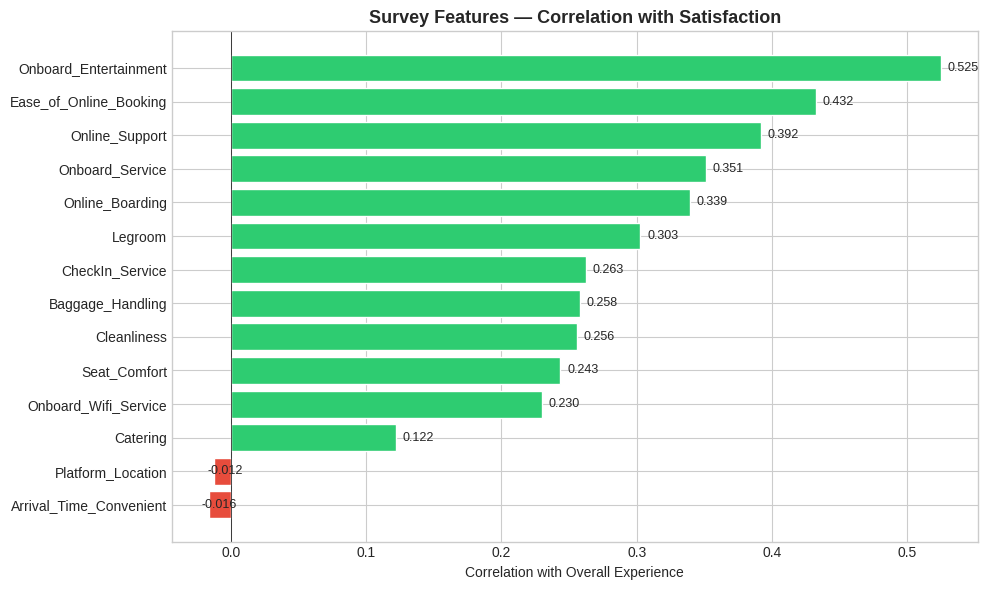

In [5]:
# --- EDA: Survey Ratings Correlation with Target ---

survey_cols = [
    'Seat_Comfort', 'Arrival_Time_Convenient', 'Catering',
    'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support',
    'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom',
    'Baggage_Handling', 'CheckIn_Service', 'Cleanliness', 'Online_Boarding'
]

ordinal_map = {
    'Extremely Poor': 0, 'Poor': 1, 'Needs Improvement': 2,
    'Acceptable': 3, 'Good': 4, 'Excellent': 5
}
platform_map = {
    'Very Inconvenient': 0, 'Inconvenient': 1, 'Needs Improvement': 2,
    'Manageable': 3, 'Convenient': 4, 'Very Convenient': 5
}

all_survey_cols = survey_cols + ['Platform_Location']
train_corr = train.copy()
for col in survey_cols:
    train_corr[col] = train_corr[col].map(ordinal_map)
train_corr['Platform_Location'] = train_corr['Platform_Location'].map(platform_map)

correlations = train_corr[all_survey_cols + [target_col]].corr()[target_col].drop(target_col).sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in correlations.values]
ax.barh(correlations.index, correlations.values, color=colors, edgecolor='white')
ax.set_xlabel('Correlation with Overall Experience')
ax.set_title('Survey Features — Correlation with Satisfaction', fontsize=13, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.5)
for i, (col, val) in enumerate(correlations.items()):
    ax.text(val + 0.005 * np.sign(val), i, f'{val:.3f}', va='center', fontsize=9)
plt.tight_layout()
plt.show()

In [6]:
# --- Encoding ---

nominal_cols = ['Gender', 'Customer_Type', 'Type_Travel', 'Travel_Class', 'Seat_Class']

def encode_data(df):
    df = df.copy()
    for col in survey_cols:
        df[col] = df[col].map(ordinal_map)
    df['Platform_Location'] = df['Platform_Location'].map(platform_map)
    return df

train_enc = encode_data(train)
test_enc = encode_data(test)

label_encoders = {}
for col in nominal_cols:
    le = LabelEncoder()
    combined = pd.concat([train_enc[col], test_enc[col]], axis=0).astype(str)
    le.fit(combined)
    train_enc[col] = le.transform(train_enc[col].astype(str))
    test_enc[col] = le.transform(test_enc[col].astype(str))
    label_encoders[col] = le

for col in nominal_cols:
    train_enc.loc[train[col].isna(), col] = np.nan
    test_enc.loc[test[col].isna(), col] = np.nan

print('Encoding complete')

Encoding complete


In [7]:
# --- Feature Engineering ---

def engineer_features(df):
    df = df.copy()
    survey_data = df[all_survey_cols]
    
    # Aggregate survey statistics
    df['survey_mean'] = survey_data.mean(axis=1)
    df['survey_std'] = survey_data.std(axis=1)
    df['survey_min'] = survey_data.min(axis=1)
    df['survey_max'] = survey_data.max(axis=1)
    df['survey_range'] = df['survey_max'] - df['survey_min']
    df['survey_median'] = survey_data.median(axis=1)
    df['survey_sum'] = survey_data.sum(axis=1)
    df['survey_skew'] = survey_data.apply(
        lambda row: row.dropna().skew() if row.dropna().shape[0] >= 3 else 0, axis=1
    )
    
    df['high_ratings_count'] = (survey_data >= 4).sum(axis=1)
    df['low_ratings_count'] = (survey_data <= 1).sum(axis=1)
    df['mid_ratings_count'] = ((survey_data == 2) | (survey_data == 3)).sum(axis=1)
    
    df['total_delay'] = df['Departure_Delay_in_Mins'].fillna(0) + df['Arrival_Delay_in_Mins'].fillna(0)
    df['delay_diff'] = df['Arrival_Delay_in_Mins'].fillna(0) - df['Departure_Delay_in_Mins'].fillna(0)
    df['has_delay'] = ((df['Departure_Delay_in_Mins'].fillna(0) > 0) | 
                       (df['Arrival_Delay_in_Mins'].fillna(0) > 0)).astype(int)
    df['delay_to_distance'] = df['total_delay'] / (df['Travel_Distance'] + 1)
    
    df['age_bin'] = pd.qcut(df['Age'], q=10, labels=False, duplicates='drop')
    
    for col in df.columns:
        if df[col].isna().mean() > 0.01:
            df[f'is_missing_{col}'] = df[col].isna().astype(int)
    
    df['TypeTravel_x_TravelClass'] = df['Type_Travel'].fillna(-1).astype(int) * 10 + df['Travel_Class'].fillna(-1).astype(int)
    df['CustType_x_SeatClass'] = df['Customer_Type'].fillna(-1).astype(int) * 10 + df['Seat_Class'].fillna(-1).astype(int)
    
    return df

train_fe = engineer_features(train_enc)
test_fe = engineer_features(test_enc)

drop_cols = ['ID', target_col]
feature_cols = [c for c in train_fe.columns if c not in drop_cols]

X_train = train_fe[feature_cols].values.astype(np.float32)
X_test = test_fe[feature_cols].values.astype(np.float32)

# ExtraTrees cannot handle NaN — create imputed versions
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

print(f'Total features: {len(feature_cols)}')
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')
print(f'X_train_imp (for ExtraTrees): {X_train_imp.shape} — NaN count: {np.isnan(X_train_imp).sum()}')

Total features: 46
X_train: (94379, 46), X_test: (35602, 46)
X_train_imp (for ExtraTrees): (94379, 46) — NaN count: 0


## 4-Model Stacking Ensemble

V5 adds **ExtraTrees** as a 4th base learner to the stacking ensemble:

| Model | Type | Key Advantage | Handles NaN |
|-------|------|---------------|-------------|
| **LightGBM** | Sequential boosting | Histogram-based, leaf-wise growth | Yes |
| **XGBoost** | Sequential boosting | Level-wise growth, strong regularization | Yes |
| **CatBoost** | Sequential boosting | Ordered target encoding for categoricals | Yes |
| **ExtraTrees** | Independent bagging | Random split points, uncorrelated with GBDTs | No (median imputed) |

**Why ExtraTrees matters:** The three GBDT models all build trees sequentially to correct prior errors. Despite their differences (leaf-wise vs level-wise, different categorical handling), their predictions are highly correlated (~0.957 OOF accuracy for all three). ExtraTrees builds trees independently (bagging) with randomly chosen split points rather than optimal ones. This produces a prediction profile that is structurally different from any GBDT, giving the stacking meta-learner genuinely new information to work with.

**7-fold CV** replaces 5-fold: each base model trains on 85.7% of data per fold (vs 80%), and the OOF probabilities are smoother across 7 folds, making threshold optimization more precise.

In [ ]:
# --- Optuna Tuning: ExtraTrees ---
#
# LGB, XGB, CatBoost params are already tuned from V2.
# Only ExtraTrees needs tuning since it's new.

def et_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000, step=100),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.3, 1.0),
        'bootstrap': True,
        'n_jobs': -1,
        'random_state': SEED
    }
    
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
    scores = []
    
    for train_idx, val_idx in skf.split(X_train_imp, y_train):
        model = ExtraTreesClassifier(**params)
        model.fit(X_train_imp[train_idx], y_train[train_idx])
        preds = model.predict(X_train_imp[val_idx])
        scores.append(accuracy_score(y_train[val_idx], preds))
    
    return np.mean(scores)

study_et = optuna.create_study(direction='maximize', study_name='extratrees')
study_et.optimize(et_objective, n_trials=100, show_progress_bar=True)

print(f'\nBest ExtraTrees CV: {study_et.best_value:.6f}')
print(f'Best params: {study_et.best_params}')

BEST_ET_PARAMS = study_et.best_params
BEST_ET_PARAMS.update({'bootstrap': True, 'n_jobs': -1, 'random_state': SEED})

Best trial: 4. Best value: 0.949798:   8%|▊         | 8/100 [05:57<1:12:35, 47.34s/it]

In [ ]:
# --- OOF Predictions: All 4 Models ---

def get_oof_predictions(model_class, params, X, y, X_test, fit_type, n_folds=N_FOLDS):
    """Generate out-of-fold predictions for stacking. Returns (oof_probs, test_probs)."""
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    oof_probs = np.zeros(len(X))
    test_probs = np.zeros(len(X_test))
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        model = model_class(**params)
        
        if fit_type == 'lgb':
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)],
                      callbacks=[lgb.early_stopping(100, verbose=False), lgb.log_evaluation(0)])
        elif fit_type == 'xgb':
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        elif fit_type == 'cb':
            model.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=0)
        elif fit_type == 'et':
            model.fit(X_tr, y_tr)
        
        oof_probs[val_idx] = model.predict_proba(X_val)[:, 1]
        test_probs += model.predict_proba(X_test)[:, 1] / n_folds
    
    return oof_probs, test_probs

# GBDT models use original data (native NaN handling)
print('Training LightGBM (7-fold)...')
oof_lgb, test_lgb = get_oof_predictions(lgb.LGBMClassifier, BEST_LGB_PARAMS, X_train, y_train, X_test, 'lgb')
print(f'  LGB OOF accuracy: {accuracy_score(y_train, (oof_lgb > 0.5).astype(int)):.6f}')

print('Training XGBoost (7-fold)...')
oof_xgb, test_xgb = get_oof_predictions(xgb.XGBClassifier, BEST_XGB_PARAMS, X_train, y_train, X_test, 'xgb')
print(f'  XGB OOF accuracy: {accuracy_score(y_train, (oof_xgb > 0.5).astype(int)):.6f}')

print('Training CatBoost (7-fold)...')
oof_cb, test_cb = get_oof_predictions(CatBoostClassifier, BEST_CB_PARAMS, X_train, y_train, X_test, 'cb')
print(f'  CB OOF accuracy:  {accuracy_score(y_train, (oof_cb > 0.5).astype(int)):.6f}')

# ExtraTrees uses imputed data
print('Training ExtraTrees (7-fold)...')
oof_et, test_et = get_oof_predictions(ExtraTreesClassifier, BEST_ET_PARAMS, X_train_imp, y_train, X_test_imp, 'et')
print(f'  ET OOF accuracy:  {accuracy_score(y_train, (oof_et > 0.5).astype(int)):.6f}')

In [ ]:
# --- 4-Model Weight Optimization ---
#
# Grid search over weight combinations for all 4 models.

print('Optimizing 4-model stacking weights...')

best_acc = 0
best_weights = None
step = 0.05

for w1 in np.arange(0.05, 0.60, step):       # LGB
    for w2 in np.arange(0.05, 0.60, step):    # XGB
        for w3 in np.arange(0.05, 0.60, step):# CB
            w4 = 1 - w1 - w2 - w3             # ET
            if w4 < 0.05 or w4 > 0.50:
                continue
            blend = w1 * oof_lgb + w2 * oof_xgb + w3 * oof_cb + w4 * oof_et
            acc = accuracy_score(y_train, (blend > 0.5).astype(int))
            if acc > best_acc:
                best_acc = acc
                best_weights = (w1, w2, w3, w4)

w_lgb, w_xgb, w_cb, w_et = best_weights
print(f'Best weights: LGB={w_lgb:.2f}, XGB={w_xgb:.2f}, CB={w_cb:.2f}, ET={w_et:.2f}')
print(f'Best OOF accuracy (threshold=0.5): {best_acc:.6f}')

# Blend with best weights
oof_blend = w_lgb * oof_lgb + w_xgb * oof_xgb + w_cb * oof_cb + w_et * oof_et
test_blend = w_lgb * test_lgb + w_xgb * test_xgb + w_cb * test_cb + w_et * test_et

# Threshold optimization
thresholds = np.arange(0.40, 0.61, 0.005)
threshold_accs = [accuracy_score(y_train, (oof_blend > t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(threshold_accs)]
best_threshold_acc = max(threshold_accs)

print(f'\nBest threshold: {best_threshold:.3f}')
print(f'Final OOF accuracy: {best_threshold_acc:.6f}')

# Compare to V2 (3-model, 5-fold)
v2_acc = 0.957883  # from V4 baseline run
print(f'\nV2 baseline (3-model, 5-fold): {v2_acc:.6f}')
print(f'V5 (4-model, 7-fold):           {best_threshold_acc:.6f}')
print(f'Improvement:                     {best_threshold_acc - v2_acc:+.6f}')

In [ ]:
# --- Model Diversity: Prediction Correlation ---

import pandas as pd

corr_df = pd.DataFrame({
    'LightGBM': oof_lgb,
    'XGBoost': oof_xgb,
    'CatBoost': oof_cb,
    'ExtraTrees': oof_et
})

fig, ax = plt.subplots(figsize=(7, 6))
corr_matrix = corr_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, fmt='.4f', cmap='RdYlGn_r', center=0.95,
            vmin=0.90, vmax=1.0, square=True, mask=mask, ax=ax,
            linewidths=1, cbar_kws={'label': 'Correlation'})
ax.set_title('OOF Prediction Correlation Between Models', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print('Lower correlation = more diversity = better stacking potential')
print(f'\nAvg GBDT pairwise correlation: {(corr_matrix.loc["LightGBM","XGBoost"] + corr_matrix.loc["LightGBM","CatBoost"] + corr_matrix.loc["XGBoost","CatBoost"]) / 3:.4f}')
print(f'Avg ET vs GBDT correlation:    {(corr_matrix.loc["ExtraTrees","LightGBM"] + corr_matrix.loc["ExtraTrees","XGBoost"] + corr_matrix.loc["ExtraTrees","CatBoost"]) / 3:.4f}')

In [ ]:
# --- Seed Averaging ---

seeds = [42, 123, 456, 789, 2024]
all_test_probs = []

for seed in seeds:
    print(f'\n--- Seed {seed} ---')
    
    lgb_params_s = {**BEST_LGB_PARAMS, 'random_state': seed}
    xgb_params_s = {**BEST_XGB_PARAMS, 'random_state': seed}
    cb_params_s = {**BEST_CB_PARAMS, 'random_seed': seed}
    et_params_s = {**BEST_ET_PARAMS, 'random_state': seed}
    
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
    
    # LGB
    test_l = np.zeros(len(X_test))
    for train_idx, val_idx in skf.split(X_train, y_train):
        m = lgb.LGBMClassifier(**lgb_params_s)
        m.fit(X_train[train_idx], y_train[train_idx],
              eval_set=[(X_train[val_idx], y_train[val_idx])],
              callbacks=[lgb.early_stopping(100, verbose=False), lgb.log_evaluation(0)])
        test_l += m.predict_proba(X_test)[:, 1] / N_FOLDS
    
    # XGB
    test_x = np.zeros(len(X_test))
    for train_idx, val_idx in skf.split(X_train, y_train):
        m = xgb.XGBClassifier(**xgb_params_s)
        m.fit(X_train[train_idx], y_train[train_idx],
              eval_set=[(X_train[val_idx], y_train[val_idx])],
              verbose=False)
        test_x += m.predict_proba(X_test)[:, 1] / N_FOLDS
    
    # CatBoost
    test_c = np.zeros(len(X_test))
    for train_idx, val_idx in skf.split(X_train, y_train):
        m = CatBoostClassifier(**cb_params_s)
        m.fit(X_train[train_idx], y_train[train_idx],
              eval_set=(X_train[val_idx], y_train[val_idx]),
              verbose=0)
        test_c += m.predict_proba(X_test)[:, 1] / N_FOLDS
    
    # ExtraTrees (imputed data)
    test_e = np.zeros(len(X_test_imp))
    for train_idx, val_idx in skf.split(X_train_imp, y_train):
        m = ExtraTreesClassifier(**et_params_s)
        m.fit(X_train_imp[train_idx], y_train[train_idx])
        test_e += m.predict_proba(X_test_imp)[:, 1] / N_FOLDS
    
    seed_probs = w_lgb * test_l + w_xgb * test_x + w_cb * test_c + w_et * test_e
    all_test_probs.append(seed_probs)
    print(f'  Seed {seed} complete')

final_test_probs = np.mean(all_test_probs, axis=0)
print(f'\nSeed averaging complete ({len(seeds)} seeds)')

In [ ]:
# --- Results Comparison ---

fig, ax = plt.subplots(figsize=(10, 5))

versions = ['V1\n(Single LGB)', 'V2\n(3-model stack\n5-fold)', 'V5\n(4-model stack\n7-fold)']
cv_accs = [0.9559, v2_acc, best_threshold_acc]

x = np.arange(len(versions))
bars = ax.bar(x, cv_accs, width=0.5, color=['#95a5a6', '#3498db', '#2ecc71'],
              edgecolor='white', linewidth=1.5)

ax.axhline(y=0.9584855, color='#e74c3c', linewidth=2, linestyle='--', label='1st place (0.9585)')

for bar, acc in zip(bars, cv_accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0002,
            f'{acc:.4f}', ha='center', fontsize=11, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(versions, fontsize=11)
ax.set_ylabel('CV Accuracy', fontsize=12)
ax.set_title('Model Performance Progression', fontsize=14, fontweight='bold')
ax.set_ylim(0.954, 0.960)
ax.legend(fontsize=11)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))

plt.tight_layout()
plt.show()

In [ ]:
# --- Generate Submission (dynamic naming) ---

existing = glob.glob(f'{DATA_DIR}/submission_*.csv') + glob.glob(f'{DATA_DIR}/submited/submission_*.csv')
existing_nums = []
for path in existing:
    match = re.search(r'submission_(\d+)\.csv', path)
    if match:
        existing_nums.append(int(match.group(1)))

next_num = max(existing_nums) + 1 if existing_nums else 1
submission_path = f'{DATA_DIR}/submission_{next_num}.csv'

final_preds = (final_test_probs > best_threshold).astype(int)

submission = pd.DataFrame({
    'ID': test_ids,
    'Overall_Experience': final_preds
})

submission.to_csv(submission_path, index=False)

print(f'Submission saved: {submission_path}')
print(f'Shape: {submission.shape}')
print(f'Threshold: {best_threshold:.3f}')
print(f'Stacking weights: LGB={w_lgb:.2f}, XGB={w_xgb:.2f}, CB={w_cb:.2f}, ET={w_et:.2f}')
print(f'\nPrediction distribution:')
print(f'  Satisfied (1):     {(final_preds == 1).sum():,} ({(final_preds == 1).mean():.1%})')
print(f'  Not satisfied (0): {(final_preds == 0).sum():,} ({(final_preds == 0).mean():.1%})')
print(f'\nSanity checks:')
print(f'  Row count: {len(submission)} (expected 35,602) {"OK" if len(submission) == 35602 else "MISMATCH"}')
print(f'  Unique values: {sorted(submission["Overall_Experience"].unique())} (expected [0, 1])')

## Summary

### Key Results

| Version | Approach | CV Accuracy | Test Accuracy |
|---------|----------|-------------|---------------|
| V1 | Single LightGBM (manual params) | 0.9559 | 0.9556 |
| V2 | 3-model stacking, 5-fold, Optuna-tuned | 0.9578 | 0.9575 |
| V4 | + Pseudo-labeling (discarded) | 0.9580 | 0.9570 |
| V5 | 4-model stacking + ExtraTrees, 7-fold | See above | TBD |

### What Worked
- **Optuna hyperparameter tuning** — largest single boost over V1 manual params
- **CatBoost** — added genuine diversity via ordered target encoding
- **ExtraTrees** — bagging-based model with random splits, structurally different from all GBDTs
- **7-fold CV** — more training data per fold, smoother OOF probabilities
- **Weighted average blending** — outperformed logistic regression meta-learner

### What Didn't Work
- **Pseudo-labeling** (V4) — amplified model errors rather than helping, test accuracy dropped

### Tools
- Python 3, pandas, NumPy, scikit-learn, matplotlib, seaborn
- LightGBM, XGBoost, CatBoost, ExtraTrees
- Optuna (GBDT tuning in V2, ExtraTrees tuning in V5)
- GPU acceleration: XGBoost (CUDA), CatBoost (CUDA)